# (PROTOTYPE) Predictive Stock Trading Through Machine Learning  with Sklearn's Linear Regression

Time Submitted: () GMT+8, ()

## Testing Grounds

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
from adjustText import adjust_text

In [5]:
"""import pip
import conda
pip.main(['install','plotly'])"""

Operation cancelled by user


1

## Part 1: Predict JFC stocks from 3/5/18 - 3/16/18 then compare with latest WSJ Data 

Since Google Finance data is not currently updated, we could get data from Wall Street Journal. Instead of using an API, we have to download csv files from the website.
Download csv file of JFC prices from 2013-1-1 to 2018-3-17.

Source: http://quotes.wsj.com/PH/XPHS/JFC/historical-prices

Import data.

In [9]:
stock = pd.read_csv('JFC_WSJ(for Prototype).csv')

Inspect dataframe.

In [10]:
stock.columns

Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')

Remove spaces from column names by renaming them.

In [11]:
stock.rename(columns=lambda x: x.strip(), inplace=True)
stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [12]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 6 columns):
Date      1268 non-null object
Open      1268 non-null float64
High      1268 non-null float64
Low       1268 non-null float64
Close     1268 non-null float64
Volume    1268 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.5+ KB


In [13]:
stock.head()

,Date,Open,High,Low,Close,Volume
0,03/16/18,286.8,305.4,286.8,305.4,2052470
1,03/15/18,288.4,288.6,282.6,284.0,1140780
2,03/14/18,293.0,294.4,287.4,288.4,757340
3,03/13/18,296.0,297.0,292.4,293.0,557650
4,03/12/18,296.0,299.0,292.2,295.4,303520


In [14]:
stock.tail()

,Date,Open,High,Low,Close,Volume
1263,01/08/13,107.1,107.7,107.1,107.3,389530
1264,01/07/13,107.5,107.5,106.7,107.0,719780
1265,01/04/13,107.0,107.6,107.0,107.6,548040
1266,01/03/13,104.8,107.5,104.8,107.2,684290
1267,01/02/13,102.0,104.5,102.0,104.2,125900


In [15]:
stock.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No NaN values!!!
However, we have to rearrange the data from descending to ascending order.

In [16]:
stock = stock.reindex(index=stock.index[::-1]).reset_index(drop=True)

In [17]:
stock.head()

,Date,Open,High,Low,Close,Volume
0,01/02/13,102.0,104.5,102.0,104.2,125900
1,01/03/13,104.8,107.5,104.8,107.2,684290
2,01/04/13,107.0,107.6,107.0,107.6,548040
3,01/07/13,107.5,107.5,106.7,107.0,719780
4,01/08/13,107.1,107.7,107.1,107.3,389530


In [18]:
stock.tail()

,Date,Open,High,Low,Close,Volume
1263,03/12/18,296.0,299.0,292.2,295.4,303520
1264,03/13/18,296.0,297.0,292.4,293.0,557650
1265,03/14/18,293.0,294.4,287.4,288.4,757340
1266,03/15/18,288.4,288.6,282.6,284.0,1140780
1267,03/16/18,286.8,305.4,286.8,305.4,2052470


Convert 'Date' column as datetime objects and set it as index column.

In [19]:
stock['Date'] = pd.to_datetime(stock['Date'], infer_datetime_format=True)

In [20]:
stock.set_index('Date',inplace=True)

In [21]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1268 entries, 2013-01-02 to 2018-03-16
Data columns (total 5 columns):
Open      1268 non-null float64
High      1268 non-null float64
Low       1268 non-null float64
Close     1268 non-null float64
Volume    1268 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.4 KB


In [22]:
type(stock.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [23]:
stock.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-12,296.0,299.0,292.2,295.4,303520
2018-03-13,296.0,297.0,292.4,293.0,557650
2018-03-14,293.0,294.4,287.4,288.4,757340
2018-03-15,288.4,288.6,282.6,284.0,1140780
2018-03-16,286.8,305.4,286.8,305.4,2052470


Create Copy for exercise.

In [24]:
stockC = stock[stock.index.isin(pd.date_range(start='2013-01-01', end='2018-03-16'))]
stockC.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-05,299.0,300.0,296.0,299.6,388840
2018-03-06,300.0,304.0,297.8,298.6,833460
2018-03-07,300.0,304.0,299.8,304.0,853340
2018-03-08,303.0,304.0,295.0,295.0,367970
2018-03-09,297.0,297.0,292.0,292.0,352590
2018-03-12,296.0,299.0,292.2,295.4,303520
2018-03-13,296.0,297.0,292.4,293.0,557650
2018-03-14,293.0,294.4,287.4,288.4,757340
2018-03-15,288.4,288.6,282.6,284.0,1140780


Notice that there are no values for 3/3 and 3/4. Trading days excluse weekends and holidays.

Add Prediction column which contains the predicted Close column value n trading days later.

The contents of the new column are just the values of the Close column shifted 5 days backwards, therefore, n=-5

In [25]:
n=-10
stockC['Prediction'] = stockC['Close'].shift(n)
stockC.tail(11)

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2018-03-02,297.6,298.4,295.0,298.0,735080,305.4
2018-03-05,299.0,300.0,296.0,299.6,388840,NaN
2018-03-06,300.0,304.0,297.8,298.6,833460,NaN
2018-03-07,300.0,304.0,299.8,304.0,853340,NaN
2018-03-08,303.0,304.0,295.0,295.0,367970,NaN
2018-03-09,297.0,297.0,292.0,292.0,352590,NaN
2018-03-12,296.0,299.0,292.2,295.4,303520,NaN
2018-03-13,296.0,297.0,292.4,293.0,557650,NaN
2018-03-14,293.0,294.4,287.4,288.4,757340,NaN


In [26]:
len(stockC)

1268

In order to prepare the data for machine learning, we have to delete all rows with NaN values.

In [27]:
from sklearn import preprocessing

In [28]:
X = preprocessing.scale(stockC.drop(['Prediction'], axis=1))

In [29]:
X_predict = X[n:]
X = X[:n]

In [30]:
y = stockC['Prediction'][:n]

In [31]:
print(type(X), type(X_predict), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [32]:
print(len(X), len(X_predict), len(y))

1258 10 1258


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2))

In [35]:
print(type(X_train), type(X_test), type(y_train), type(y_test) )

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [36]:
print(len(X_train), len(X_test), len(y_train), len(y_test) )

1006 252 1006 252


In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
lm = LinearRegression()

In [39]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Cross Validation

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

lm = SVR(kernel='linear', C=1)
scores = cross_val_score(lm, X, y, cv=10)
scores #score for each split

array([0.69694137, 0.07248903, 0.30929769, 0.73236715, 0.46188133,
       0.40399605, 0.65348755, 0.60289925, 0.4340348 , 0.65228796])

In [41]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.50 (+/- 0.39)


In [42]:
lm.fit(X_train, y_train)
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 95.36502495442556%


### Predictions

In [43]:
predictions = lm.predict(X_test)

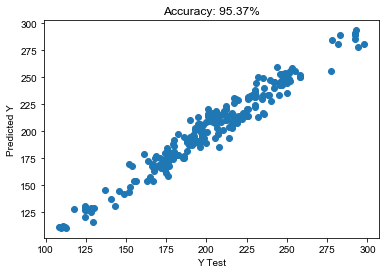

In [44]:
plt.scatter(y_test,predictions)
plt.title('Accuracy: '+str((accuracy*100).round(2))+'%')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
sns.set_style('whitegrid')

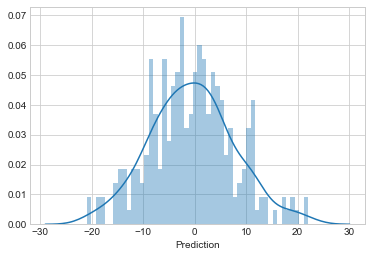

In [45]:
sns.distplot((y_test-predictions),bins=50)

In [46]:
predr_i = stock.index.get_loc(pd.Timestamp('2018-03-5'))
predr_i

1258

In [47]:
predr_f = stock.index.get_loc(pd.Timestamp('2018-03-16'))
predr_f

1267

In [48]:
predr_index = stock.index[predr_i:predr_f+1]
predr_index

DatetimeIndex(['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
               '2018-03-09', '2018-03-12', '2018-03-13', '2018-03-14',
               '2018-03-15', '2018-03-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [49]:
stock_later = lm.predict(X_predict)
Predicted_stock = pd.Series(stock_later, index=predr_index).round(2)
print('Predicted values for 3/5-3/16: \n') 
print(Predicted_stock)

Predicted values for 3/5-3/16: 

Date
2018-03-05    298.21
2018-03-06    300.18
2018-03-07    302.22
2018-03-08    298.40
2018-03-09    293.89
2018-03-12    295.08
2018-03-13    294.35
2018-03-14    290.78
2018-03-15    286.48
2018-03-16    298.37
dtype: float64


Actual values

In [50]:
Actual = pd.Series(stock['Close'].loc[predr_index])
print(Actual)

Date
2018-03-05    299.6
2018-03-06    298.6
2018-03-07    304.0
2018-03-08    295.0
2018-03-09    292.0
2018-03-12    295.4
2018-03-13    293.0
2018-03-14    288.4
2018-03-15    284.0
2018-03-16    305.4
Name: Close, dtype: float64


Create dataframe for comparison.

In [51]:
stock_c = pd.DataFrame({'Actual':Actual,'Predicted':Predicted_stock}).set_index(predr_index).round(2)
stock_c

,Actual,Predicted
Date,,
2018-03-05,299.6,298.21
2018-03-06,298.6,300.18
2018-03-07,304.0,302.22
2018-03-08,295.0,298.40
2018-03-09,292.0,293.89
2018-03-12,295.4,295.08
2018-03-13,293.0,294.35
2018-03-14,288.4,290.78
2018-03-15,284.0,286.48


## Part 1.2: Visualization 

In [52]:
pred_color='blue'

In [53]:
actual_color='red'

In [54]:
stock_name = 'JFC.PH'

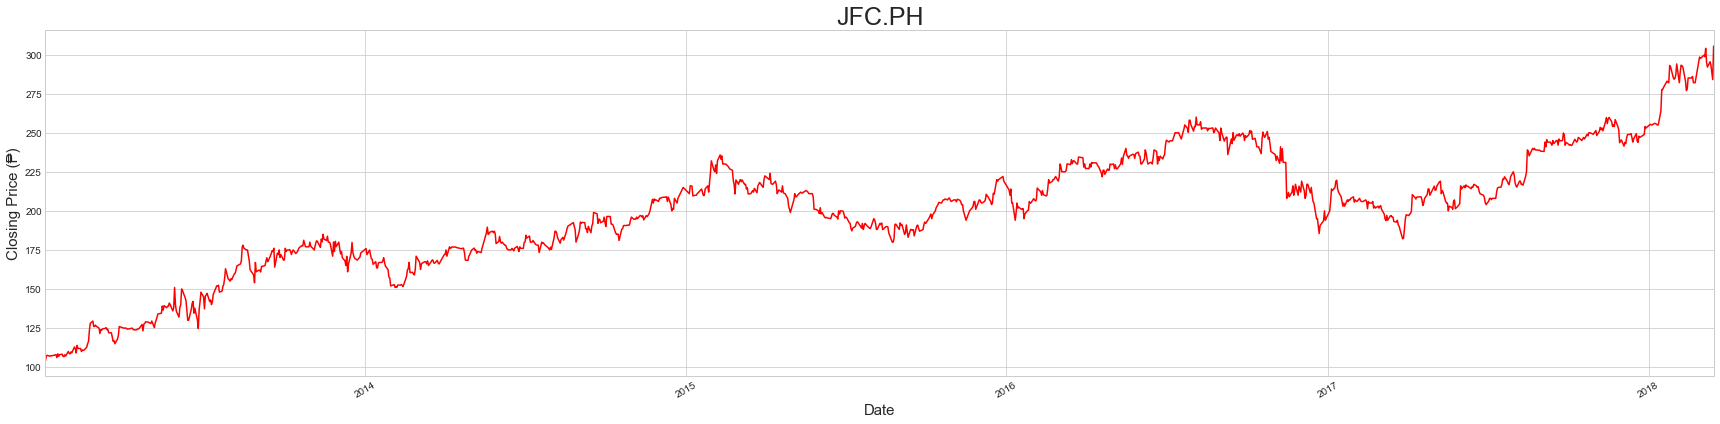

In [56]:
plt.title(stock_name, fontsize=25)

stock['Close'].plot(figsize=(24,6),legend=None, color=actual_color)

plt.ylabel('Closing Price (₱)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xlim(xmin=stock.index[0], xmax=stock.index[-1])
plt.xticks(ha='center')

plt.tight_layout()

Create linking. This will be used to link the line graphs of predicted and actual values.

In [57]:
l_i = stock['Close'].loc[stockC.index[n-1]]
l_i

298.0

In [58]:
l_f = stock_c['Predicted'][stock_c.index[0]]
l_f

298.21

In [59]:
link_i = stock.index.get_loc(pd.Timestamp('2018-03-02'))
link_i

1257

In [60]:
link_f = stock.index.get_loc(pd.Timestamp('2018-03-05'))
link_f

1258

In [61]:
link_index = stock.index[link_i:link_f+1]
link_index

DatetimeIndex(['2018-03-02', '2018-03-05'], dtype='datetime64[ns]', name='Date', freq=None)

In [62]:
stock_l = pd.DataFrame({'Link':[l_i,l_f]}, index=link_index)
stock_l

,Link
Date,
2018-03-02,298.00
2018-03-05,298.21


Combine stock_l and stock_c

In [63]:
stock_future = pd.DataFrame({'Predicted':stock_l['Link'].combine_first(stock_c['Predicted'])})
stock_future

,Predicted
Date,
2018-03-02,298.00
2018-03-05,298.21
2018-03-06,300.18
2018-03-07,302.22
2018-03-08,298.40
2018-03-09,293.89
2018-03-12,295.08
2018-03-13,294.35
2018-03-14,290.78


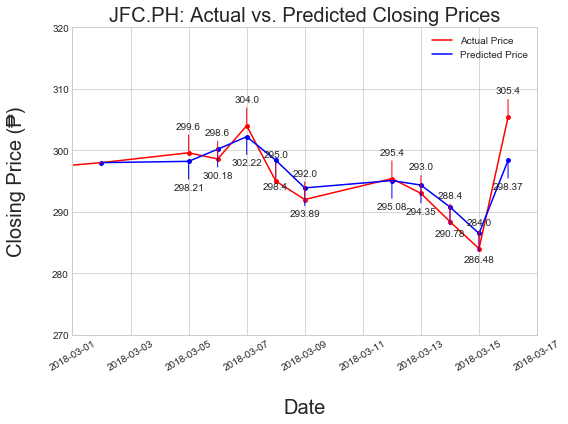

In [64]:
plt.figure(figsize=(8,6))
plt.title(stock_name + ": Actual vs. Predicted Closing Prices", fontsize=20)

stock['Close'].plot(label='Actual Price', legend=True, color=actual_color)
stock_future['Predicted'].plot(label='Predicted Price', legend=True, color=pred_color)

for i, txt in enumerate(stock_c['Predicted']):
    plt.annotate(txt, (stock_c.index[i],stock_c['Predicted'][i]), 
                xytext=(stock_c.index[i],stock_c['Predicted'][i]-5),
                horizontalalignment='center', verticalalignment='bottom',
                arrowprops=dict(arrowstyle="-",color=pred_color))
    
for i, txt in enumerate(stock_c['Actual']):
    plt.annotate(txt, (stock_c.index[i],stock_c['Actual'][i]), 
                xytext=(stock_c.index[i],stock_c['Actual'][i]+5),
                horizontalalignment='center', verticalalignment='top',
                arrowprops=dict(arrowstyle="-",color=actual_color))

plt.scatter(stock_future.index,stock_future['Predicted'], s=15, color=pred_color)
plt.scatter(stock_c.index,stock_c['Actual'], s=15, color=actual_color)

plt.xlim('2018-03-01', '2018-03-17')
plt.ylim(ymin=270,ymax=320)
plt.xlabel('\nDate', fontsize=20)
plt.ylabel('Closing Price (₱)\n', fontsize=20)
plt.xticks(ha='center')

plt.tight_layout()

# Part 2: Predict JFC stocks from 3/19/18 to 3/23/18.

In [65]:
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-01-02,102.0,104.5,102.0,104.2,125900
2013-01-03,104.8,107.5,104.8,107.2,684290
2013-01-04,107.0,107.6,107.0,107.6,548040
2013-01-07,107.5,107.5,106.7,107.0,719780
2013-01-08,107.1,107.7,107.1,107.3,389530


In [66]:
stock.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-12,296.0,299.0,292.2,295.4,303520
2018-03-13,296.0,297.0,292.4,293.0,557650
2018-03-14,293.0,294.4,287.4,288.4,757340
2018-03-15,288.4,288.6,282.6,284.0,1140780
2018-03-16,286.8,305.4,286.8,305.4,2052470


In [67]:
n=-5
stock['Prediction'] = stock['Close'].shift(n)
stock.tail(10)

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2018-03-05,299.0,300.0,296.0,299.6,388840,295.4
2018-03-06,300.0,304.0,297.8,298.6,833460,293.0
2018-03-07,300.0,304.0,299.8,304.0,853340,288.4
2018-03-08,303.0,304.0,295.0,295.0,367970,284.0
2018-03-09,297.0,297.0,292.0,292.0,352590,305.4
2018-03-12,296.0,299.0,292.2,295.4,303520,NaN
2018-03-13,296.0,297.0,292.4,293.0,557650,NaN
2018-03-14,293.0,294.4,287.4,288.4,757340,NaN
2018-03-15,288.4,288.6,282.6,284.0,1140780,NaN


In [68]:
len(stock)

1268

In [69]:
X = preprocessing.scale(stock.drop(['Prediction'], axis=1))

In [70]:
X_predict = X[n:]
X = X[:n]

In [71]:
y = stock['Prediction'][:n]

In [72]:
len(X)

1263

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.2))

In [74]:
lm.fit(X_train, y_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 97.06545333489514%


### Cross Validation 

In [77]:
lm = SVR(kernel='linear', C=1)
scores = cross_val_score(lm, X, y, cv=5)
scores #score for each split

array([0.94368836, 0.89748678, 0.72034443, 0.82092377, 0.93822865])

In [78]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.17)


In [80]:
lm.fit(X_train, y_train)
accuracy = lm.score(X_test, y_test)
print('Accuracy: '+str(accuracy*100)+'%')

Accuracy: 97.06545333489514%


### Predictions 

In [81]:
predictions = lm.predict(X_test)

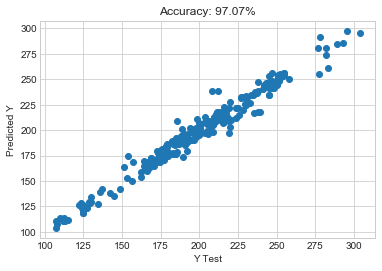

In [82]:
plt.scatter(y_test,predictions)
plt.title('Accuracy: '+str((accuracy*100).round(2))+'%')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
sns.set_style('whitegrid')

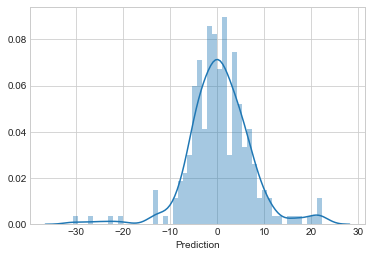

In [83]:
sns.distplot((y_test-predictions),bins=50)

In [84]:
stock_later = lm.predict(X_predict)

days = pd.DatetimeIndex(pd.date_range(datetime(2018, 3, 19), datetime(2018, 3, 19) + timedelta(4), freq='D'))
stock_future = pd.Series(stock_later, index=days)
stock_future = pd.DataFrame({'Predicted':stock_future}).set_index(days).round(2)
stock_future

,Predicted
2018-03-19,294.51
2018-03-20,293.92
2018-03-21,290.52
2018-03-22,286.44
2018-03-23,299.22


In [85]:
L_i = stock['Close'].loc['2018-03-16']
L_i

305.4

In [86]:
L_f = stock_future['Predicted'].loc['2018-03-19']
L_f

294.51

In [87]:
Linkdays = pd.DatetimeIndex(pd.date_range(datetime(2018, 3, 16), periods=2, freq="3D"))
Linkdays
stock_link = pd.DataFrame({'Predicted':[L_i,L_f]}, index=Linkdays)
stock_link

,Predicted
2018-03-16,305.40
2018-03-19,294.51


In [88]:
stock_Future = stock_link.combine_first(stock_future)
stock_Future

,Predicted
2018-03-16,305.40
2018-03-19,294.51
2018-03-20,293.92
2018-03-21,290.52
2018-03-22,286.44
2018-03-23,299.22


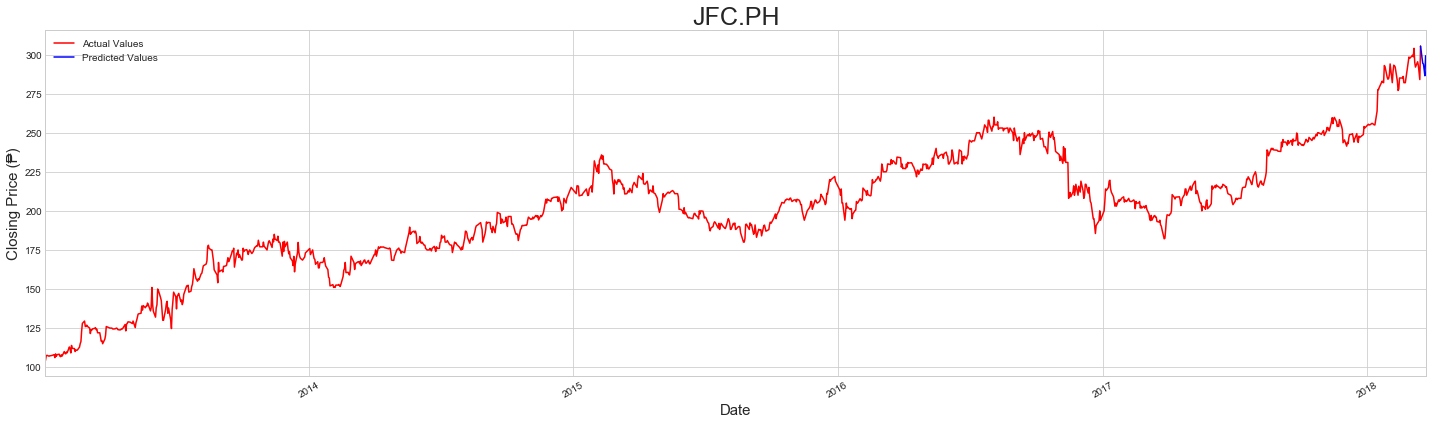

In [89]:
plt.figure(figsize=(20,6))
plt.title(stock_name, fontsize=25)

stock['Close'].plot(label='Actual Values', color=actual_color)
stock_Future['Predicted'].plot(label='Predicted Values', color=pred_color)


plt.legend()
plt.ylabel('Closing Price (₱)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xlim(xmin=stock.index[0],xmax=stock_Future.index[-1])
plt.xticks(ha='center')

plt.tight_layout()

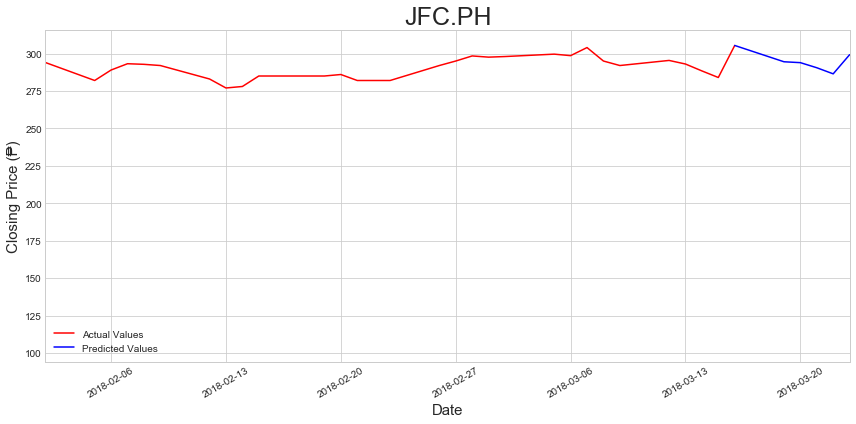

In [90]:
plt.figure(figsize=(12,6))
plt.title(stock_name, fontsize=25)

stock['Close'].plot(label='Actual Values', color=actual_color)
stock_Future['Predicted'].plot(label='Predicted Values', color=pred_color)


plt.legend()
plt.ylabel('Closing Price (₱)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xlim(xmin=stock.index[-30], xmax=stock_Future.index[-1])
plt.xticks(ha='center')

plt.tight_layout()

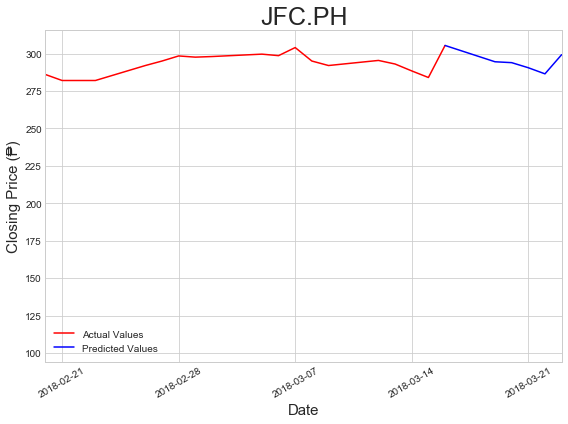

In [91]:
plt.figure(figsize=(8,6))
plt.title(stock_name, fontsize=25)

stock['Close'].plot(label='Actual Values', color=actual_color)
stock_Future['Predicted'].plot(label='Predicted Values', color=pred_color)


plt.legend()
plt.ylabel('Closing Price (₱)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xlim(xmin=stock.index[-19], xmax=stock_Future.index[-1])
plt.xticks(ha='center')

plt.tight_layout()

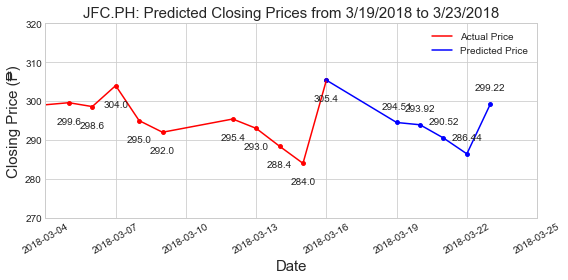

In [92]:
plt.figure(figsize=(8,4))
plt.title(stock_name+': Predicted Closing Prices from 3/19/2018 to 3/23/2018', fontsize=15)

stock['Close'].plot(label='Actual Price', color=actual_color, legend=True)
stock_Future['Predicted'].plot(label='Predicted Price', color=pred_color, legend=True)

for i, txt in enumerate(stock_future['Predicted']):
    plt.annotate(txt, (stock_future.index[i],stock_future['Predicted'][i]), 
                xytext=(stock_future.index[i],stock_future['Predicted'][i]+3),
                horizontalalignment='center', verticalalignment='bottom')
                #arrowprops=dict(arrowstyle="-",color=pred_color))
    
for i, txt in enumerate(stock_c['Actual']):
    plt.annotate(txt, (stock_c.index[i],stock_c['Actual'][i]), 
                xytext=(stock_c.index[i],stock_c['Actual'][i]-6),
                horizontalalignment='center', verticalalignment='bottom')
                #arrowprops=dict(arrowstyle="-",color=actual_color))

plt.scatter(stock_c.index,stock_c['Actual'], s=15, color =actual_color)   
plt.scatter(stock_Future.index,stock_Future['Predicted'], s=15, color=pred_color)  

plt.ylabel('Closing Price (₱)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xlim('2018-03-04', '2018-03-25')
plt.ylim(ymin=270, ymax=320)
plt.xticks(ha='center')

plt.tight_layout()